#CLASSIFICATION-Prediction of bank churn customer

##Installations

In [1]:
!pip install lazypredict
!pip install xgboost
!pip install lightgbm

     |████████████████████████████████| 14.5 MB 11.4 MB/s 
     |████████████████████████████████| 127.6 MB 19 kB/s 
     |████████████████████████████████| 72 kB 637 kB/s 
     |████████████████████████████████| 6.8 MB 24.7 MB/s 
     |████████████████████████████████| 1.2 MB 38.0 MB/s 
     |████████████████████████████████| 25.9 MB 16.3 MB/s 
     |████████████████████████████████| 269 kB 41.6 MB/s 
     |████████████████████████████████| 248 kB 37.3 MB/s 
     |████████████████████████████████| 10.1 MB 30.1 MB/s 
     |████████████████████████████████| 302 kB 19.0 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=0987439948f525283dd24796208cc409ba605faaaa8933f511fa7b881149bde9
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully

##Importing libraries

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [88]:
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,classification_report,roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV

In [89]:
from lazypredict.Supervised import LazyClassifier

from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import RandomForestClassifier as RFC

##Exploratory Data Analysis

In [6]:
#IMPORTING DATASET
DF=pd.read_csv('/content/DS3_C6_S2_Classification_BankChurn_Data_Project.csv')
DF.drop(['CustomerId','Surname'],axis=1,inplace=True)
print(DF.shape)
DF.tail(2)

(10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [7]:
DF.loc[DF['Geography']=='france', 'Geography'] = 'France'
DF.loc[DF['Geography']=='fra', 'Geography'] = 'France'
DF.loc[DF['Geography']=='ger', 'Geography'] = 'Germany'
DF.loc[DF['Geography']=='germany', 'Geography'] = 'Germany'
DF.loc[DF['Geography']=='GERMANY', 'Geography'] = 'Germany'
DF.loc[DF['Geography']=='gernamy', 'Geography'] = 'Germany'
DF.loc[DF['Geography']=='espanio', 'Geography'] = 'Spain'
DF.loc[DF['Geography']=='spain', 'Geography'] = 'Spain'
DF1=DF.copy()

In [8]:
#CHECK FOR NULL VALUES AND DATA TYPES OF COLUMNS
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [9]:
#DESCRIBING THE DATASET
DF.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.20
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.40
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00


In [10]:
#CHECKING FOR DUPLICATED VALUES-DATA QUALITY
DF[DF.duplicated()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [11]:
_df=DF.copy()
#OUTLIER TREATMENT
print('ROWS AND COLUMNS BEFORE REMOVING OUTLIERS:',_df.shape)
print()
def myoutliers(df,col):
    
    Q1=np.quantile(df[col],0.25)
    Q3=np.quantile(df[col],0.75)
    
    IQR=Q3-Q1
    
    global mylist
    global my_outlier_df
    
    UF=Q3+1.5*IQR
    LF=Q1-1.5*IQR
    
    print('LOWER RANGE OF',col,'IS',LF)
    print('UPPER RANGE OF',col,'IS',UF)
    
    mylist=[x for x in df[col] if((x<LF) | (x>UF))]
    print('TOTAL OUTLIERS IN',col,'ARE',len(mylist))
    my_outlier_df=df.loc[df[col].isin(mylist)]
    
for i in DF.select_dtypes('number'):
    print('I is', i)
    myoutliers(_df, i)
    Index=my_outlier_df.index
    _df=_df.drop(Index)
    print("************************************")
print()
print('ROWS AND COLUMNS AFTER REMOVING OUTLIERS:',_df.shape,'\n')

ROWS AND COLUMNS BEFORE REMOVING OUTLIERS: (10000, 11)

I is CreditScore
LOWER RANGE OF CreditScore IS 383.0
UPPER RANGE OF CreditScore IS 919.0
TOTAL OUTLIERS IN CreditScore ARE 15
************************************
I is Age
LOWER RANGE OF Age IS 14.0
UPPER RANGE OF Age IS 62.0
TOTAL OUTLIERS IN Age ARE 359
************************************
I is Tenure
LOWER RANGE OF Tenure IS -3.0
UPPER RANGE OF Tenure IS 13.0
TOTAL OUTLIERS IN Tenure ARE 0
************************************
I is Balance
LOWER RANGE OF Balance IS -191471.76
UPPER RANGE OF Balance IS 319119.6
TOTAL OUTLIERS IN Balance ARE 0
************************************
I is NumOfProducts
LOWER RANGE OF NumOfProducts IS -0.5
UPPER RANGE OF NumOfProducts IS 3.5
TOTAL OUTLIERS IN NumOfProducts ARE 58
************************************
I is HasCrCard
LOWER RANGE OF HasCrCard IS -1.5
UPPER RANGE OF HasCrCard IS 2.5
TOTAL OUTLIERS IN HasCrCard ARE 0
************************************
I is IsActiveMember
LOWER RANGE OF IsA

We are not going to do outlier treatment as there are not much outliers and these outliers can be ignored as they are resonable.

In [12]:
#GETTING NUMERIC and CATEGORICAL COLUMNS
DF['HasCrCard']=DF['HasCrCard'].astype('object')
DF['IsActiveMember']=DF['IsActiveMember'].astype('object')
DF['NumOfProducts']=DF['NumOfProducts'].astype('object')
DF['Exited']=DF['Exited'].astype('object')

###UNIVARIATE ANALYSIS

####UNIVARIATE ANALYSIS FOR CATEGORICAL DATA

In [13]:
categorical=DF.select_dtypes('object').columns
categorical

Index(['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'Exited'],
      dtype='object')

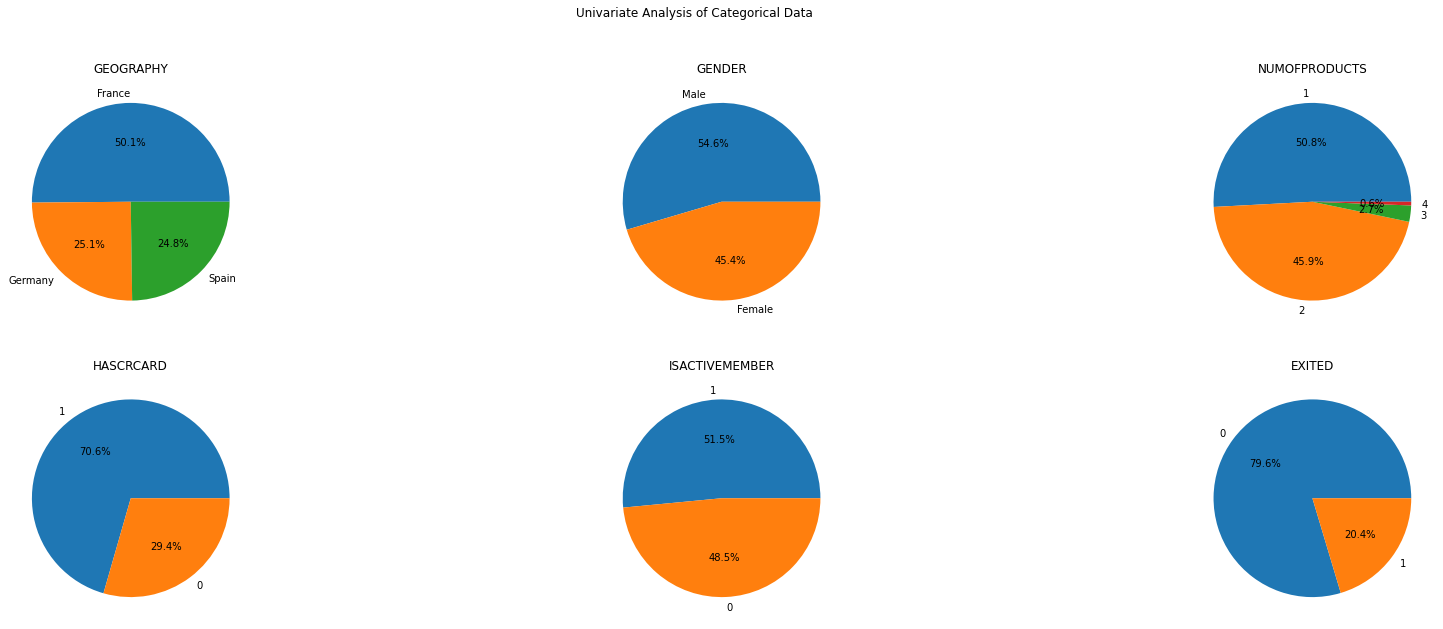

In [14]:
cat=list(enumerate(categorical))
plt.figure(figsize=(30,10))
for i in cat:
    plt.subplot(2,3,i[0]+1)                      
    d= DF[i[1]].value_counts()                                                                                                    
    labels =d.keys()      
    plt.pie(x = d, autopct = "%.1f%%", labels = labels)
    plt.title(i[1].upper())
plt.suptitle('Univariate Analysis of Categorical Data')
plt.show()

**CONCLUSION from univariate analysis:-**

*1)Most of the customers are from France geography*

*2)Most of the customers purchased one and two products*

*3)Male customers are 10% more than female customers*

*4)71% of customers have credit card*

*5)Nearly half of the customers are not active*

*6)20 % of customers exited(left) the bank while 80 % are remaining*

####UNIVARIATE ANALYSIS FOR NUMERICAL DATA

In [15]:
numerical=DF.select_dtypes('number').columns
numerical

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary'], dtype='object')

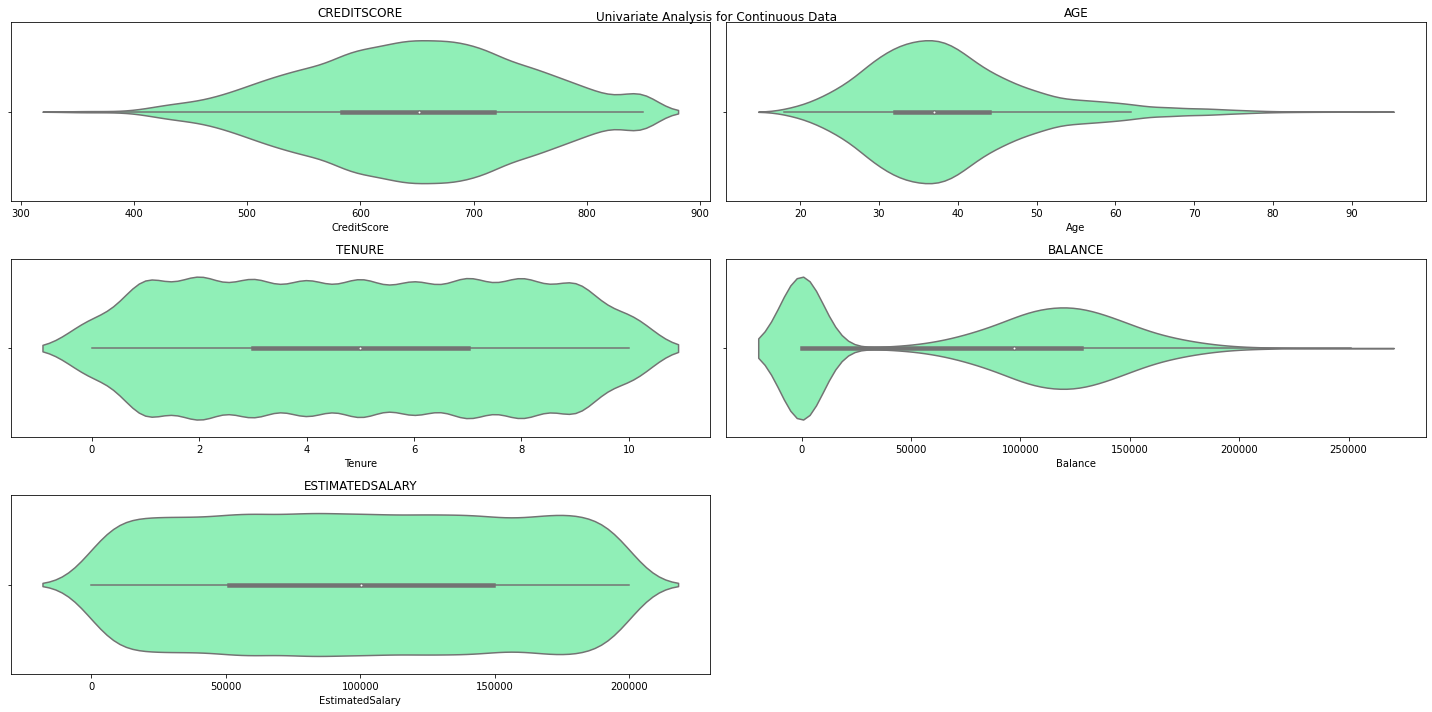

In [16]:
n=list(enumerate(numerical))
plt.figure(figsize=(20,10))
for i in n:
    plt.subplot(3,2,i[0]+1)
    sns.violinplot(x=i[1],palette='rainbow',data=DF)
    plt.title(i[1].upper())
plt.suptitle('Univariate Analysis for Continuous Data')
plt.tight_layout()
plt.show()

**CONCLUSION from unvariate analysis:-**

*1)Most of the customers have **Zero** bank balance*

*2)75% of the customers in bank are below 65 years*

*3)Average credit score customers in bank is 650*

*4)Tenure and Estimated salary are normally distributed*

###BIVARIATE ANALYSIS

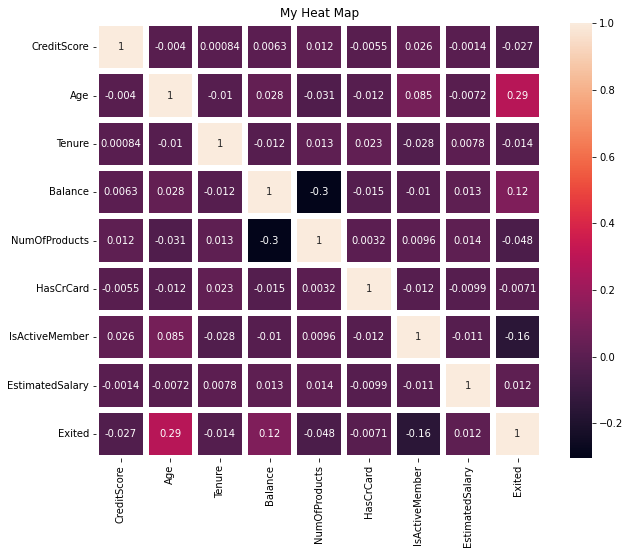

In [17]:
#FINDING RELATIONSHIP BETWEEN COLUMNS FOR BIVARIATE ANALYSIS
plt.figure(figsize=(10,8))
sns.heatmap(DF1.corr(),annot=True,linewidth=5).set_title('My Heat Map')
plt.show()

As we can see there is some correlation between the columns:- Age,Balance,IsActiveMember

Geography VS Gender


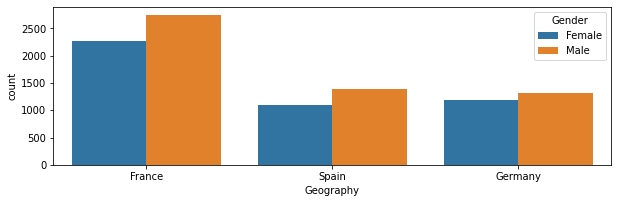

Geography VS NumOfProducts


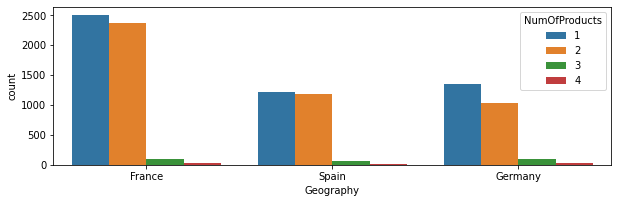

Geography VS HasCrCard


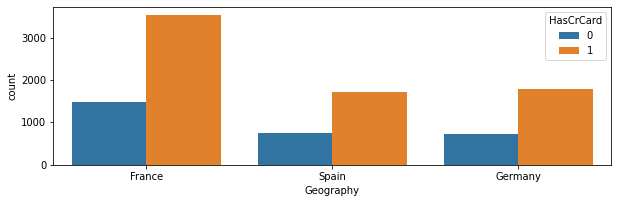

Geography VS IsActiveMember


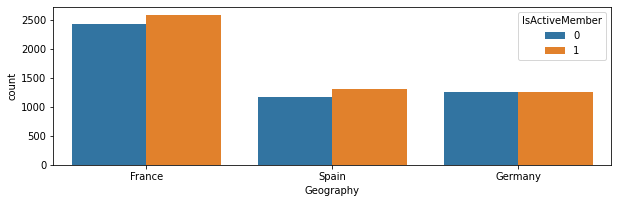

Geography VS Exited


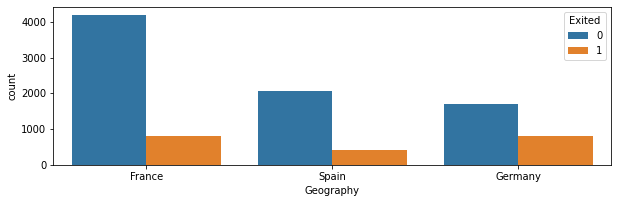

Gender VS Geography


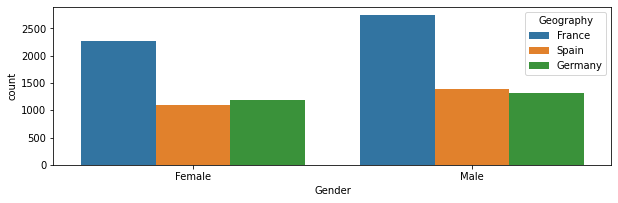

Gender VS NumOfProducts


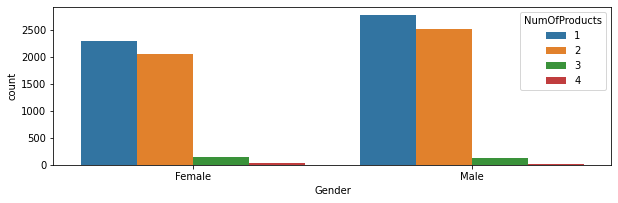

Gender VS HasCrCard


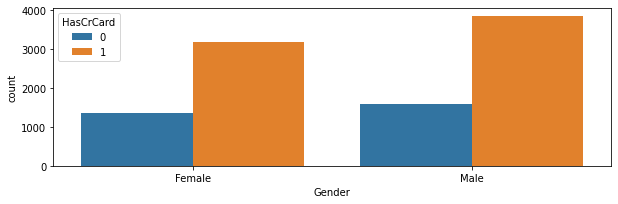

Gender VS IsActiveMember


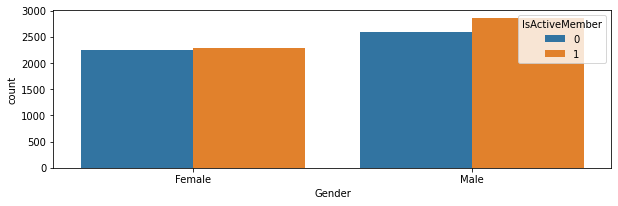

Gender VS Exited


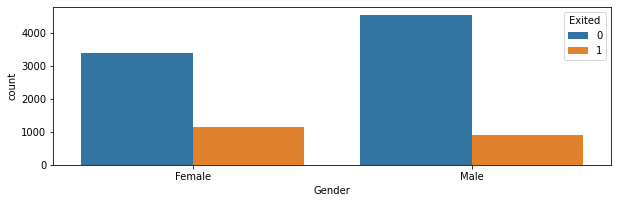

NumOfProducts VS Geography


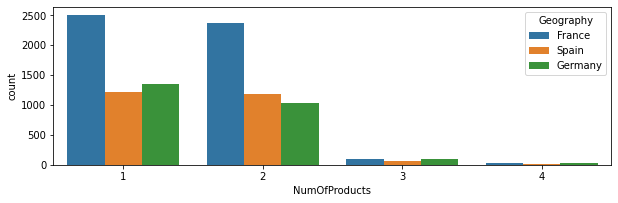

NumOfProducts VS Gender


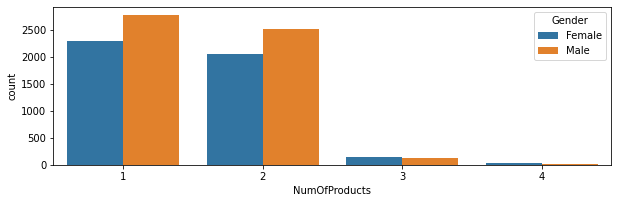

NumOfProducts VS HasCrCard


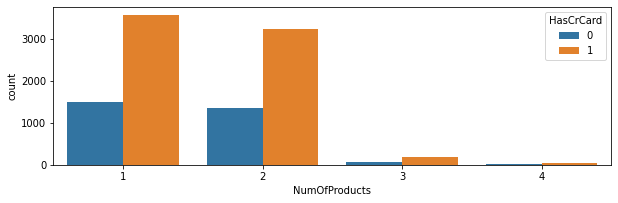

NumOfProducts VS IsActiveMember


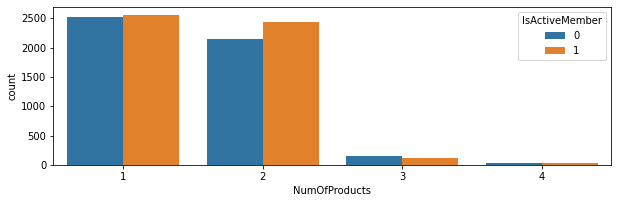

NumOfProducts VS Exited


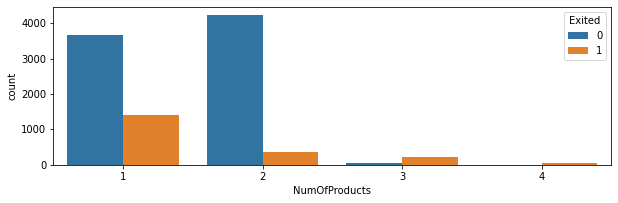

HasCrCard VS Geography


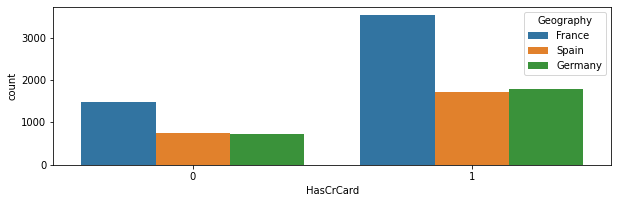

HasCrCard VS Gender


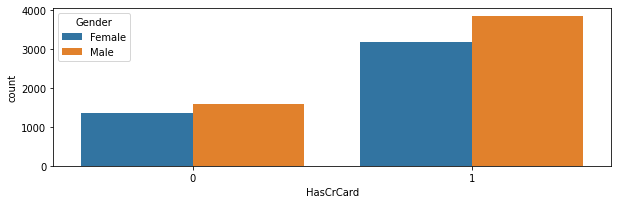

HasCrCard VS NumOfProducts


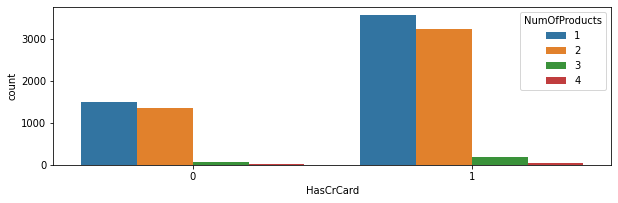

HasCrCard VS IsActiveMember


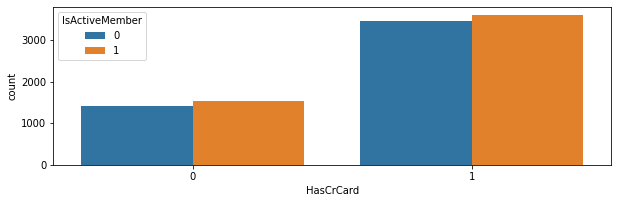

HasCrCard VS Exited


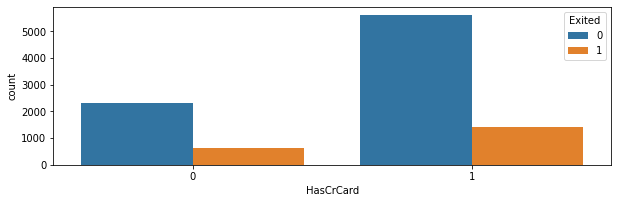

IsActiveMember VS Geography


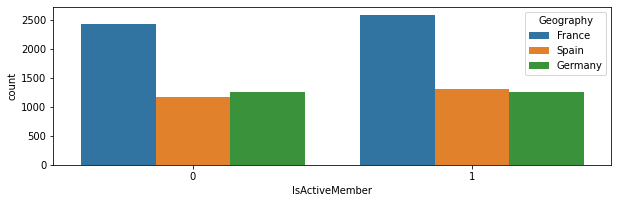

IsActiveMember VS Gender


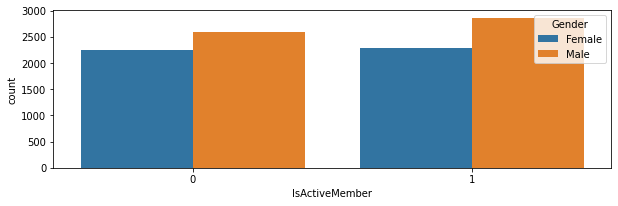

IsActiveMember VS NumOfProducts


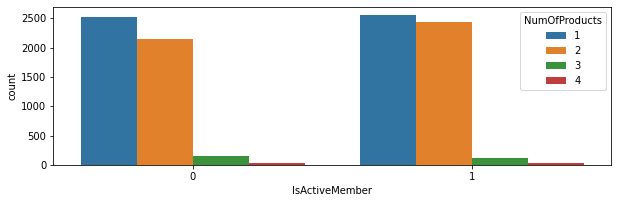

IsActiveMember VS HasCrCard


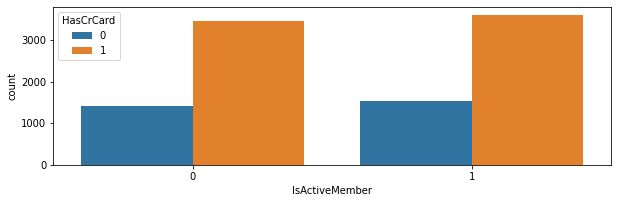

IsActiveMember VS Exited


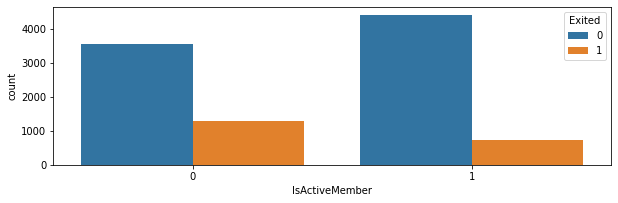

Exited VS Geography


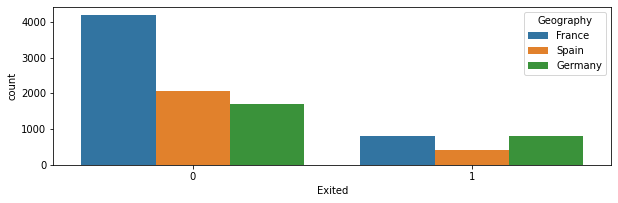

Exited VS Gender


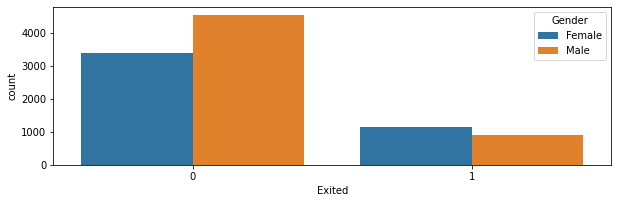

Exited VS NumOfProducts


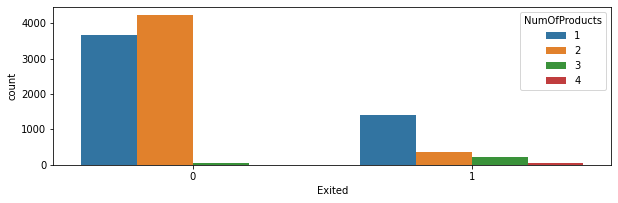

Exited VS HasCrCard


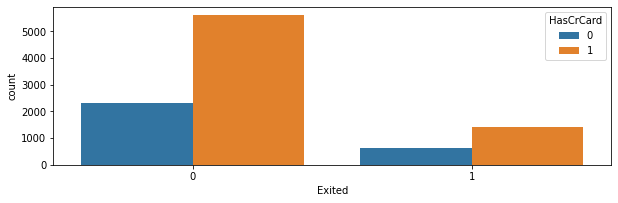

Exited VS IsActiveMember


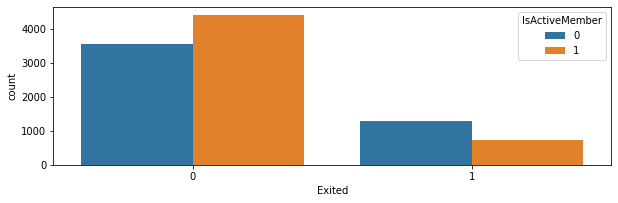

In [18]:
#CATEGORICAL TO CATEGORICAL
for i in categorical:
  for j in categorical:
    if i!=j:
      print(i,'VS',j)
      plt.figure(figsize = (10,2.9))    
      sns.countplot(x = i, hue = j, data = DF)
      plt.show()

Categorical: Geography Numerical: CreditScore


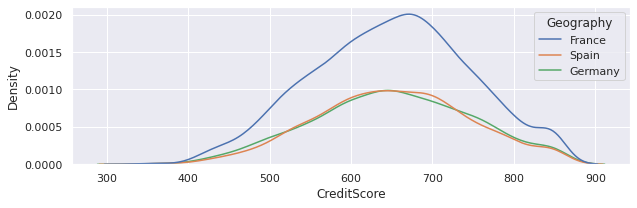

Categorical: Geography Numerical: Age


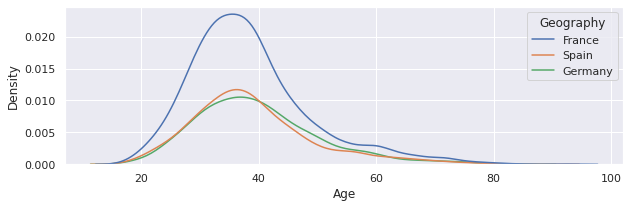

Categorical: Geography Numerical: Tenure


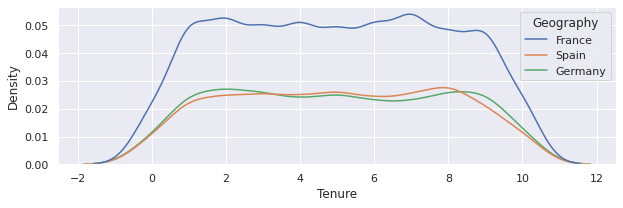

Categorical: Geography Numerical: Balance


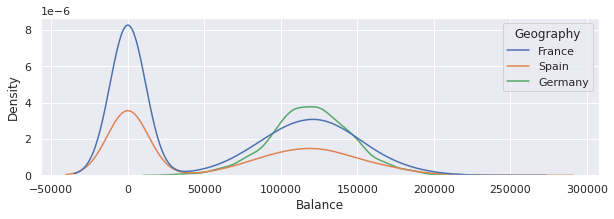

Categorical: Geography Numerical: EstimatedSalary


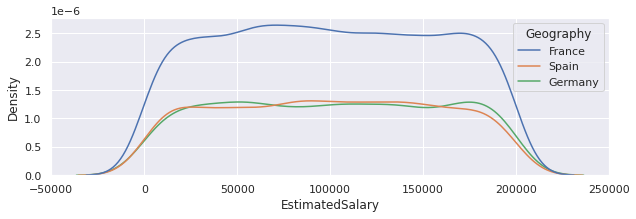

Categorical: Gender Numerical: CreditScore


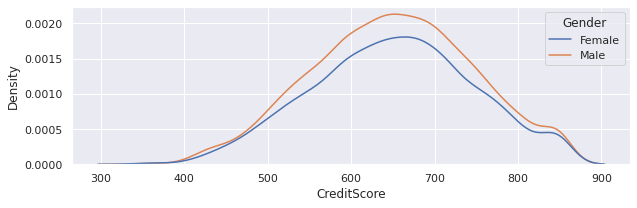

Categorical: Gender Numerical: Age


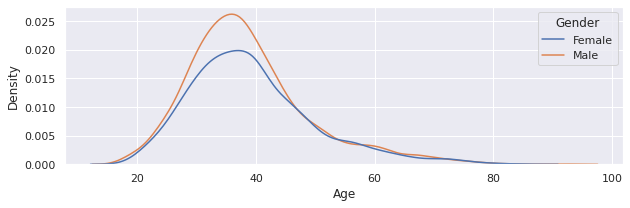

Categorical: Gender Numerical: Tenure


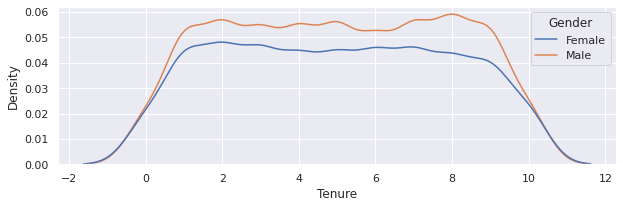

Categorical: Gender Numerical: Balance


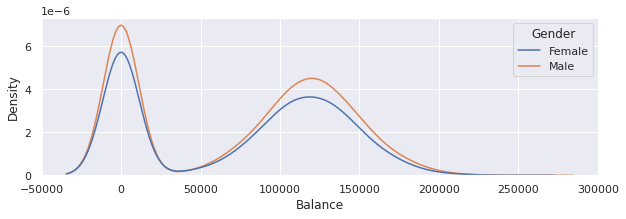

Categorical: Gender Numerical: EstimatedSalary


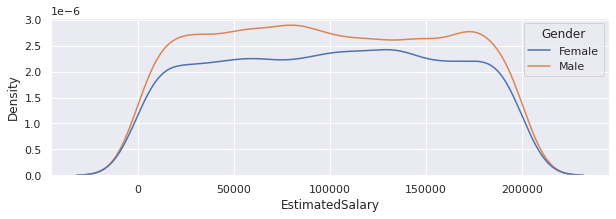

Categorical: NumOfProducts Numerical: CreditScore


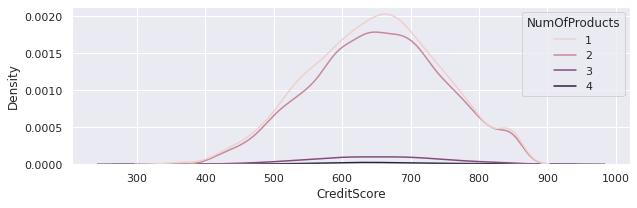

Categorical: NumOfProducts Numerical: Age


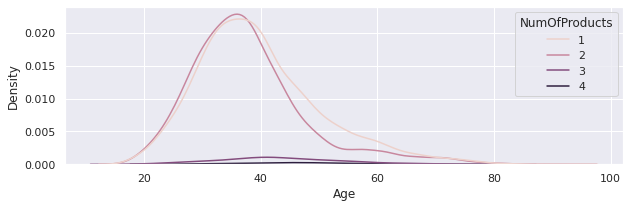

Categorical: NumOfProducts Numerical: Tenure


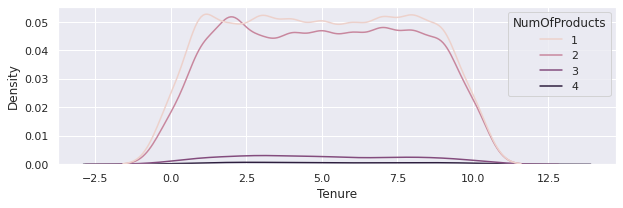

Categorical: NumOfProducts Numerical: Balance


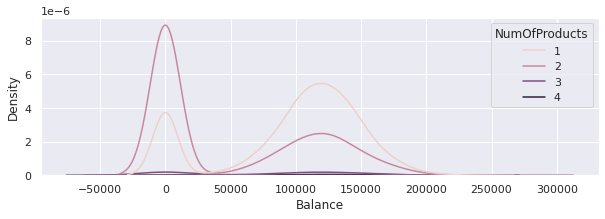

Categorical: NumOfProducts Numerical: EstimatedSalary


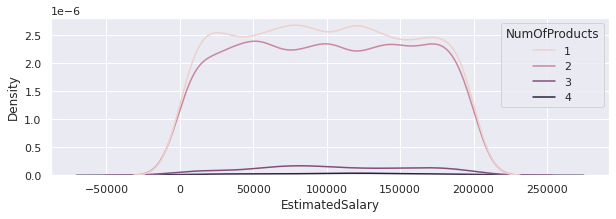

Categorical: HasCrCard Numerical: CreditScore


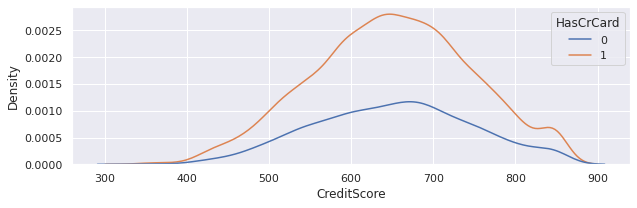

Categorical: HasCrCard Numerical: Age


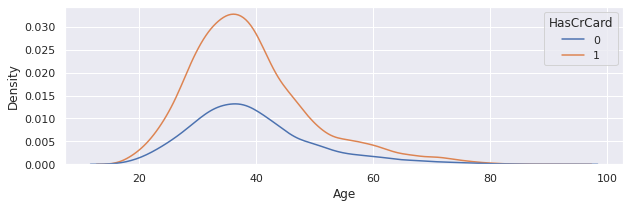

Categorical: HasCrCard Numerical: Tenure


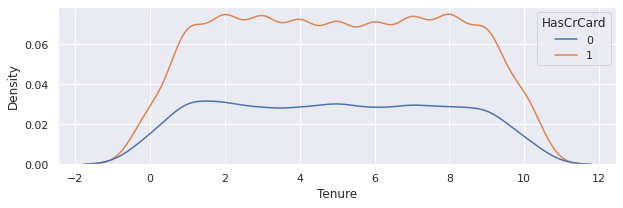

Categorical: HasCrCard Numerical: Balance


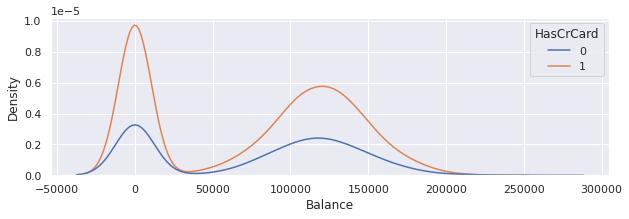

Categorical: HasCrCard Numerical: EstimatedSalary


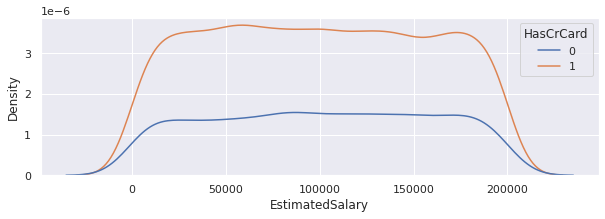

Categorical: IsActiveMember Numerical: CreditScore


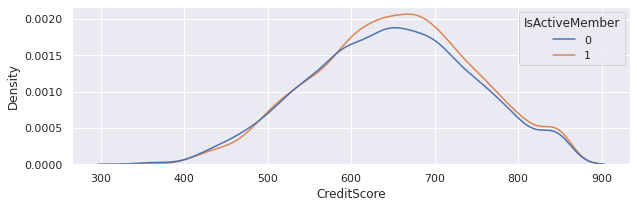

Categorical: IsActiveMember Numerical: Age


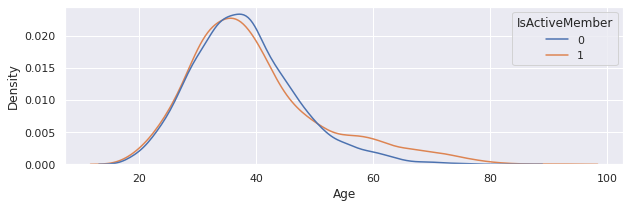

Categorical: IsActiveMember Numerical: Tenure


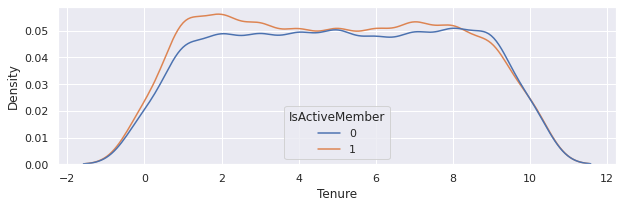

Categorical: IsActiveMember Numerical: Balance


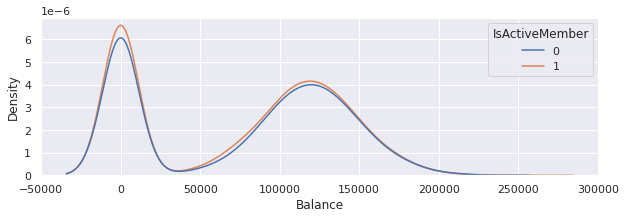

Categorical: IsActiveMember Numerical: EstimatedSalary


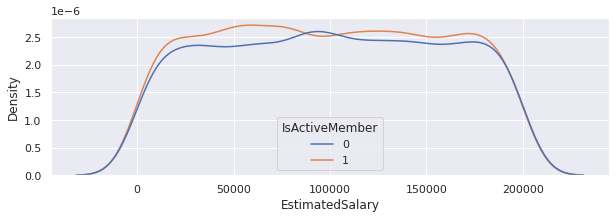

Categorical: Exited Numerical: CreditScore


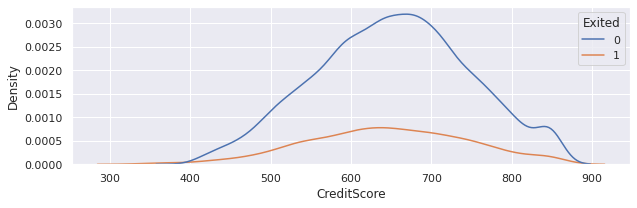

Categorical: Exited Numerical: Age


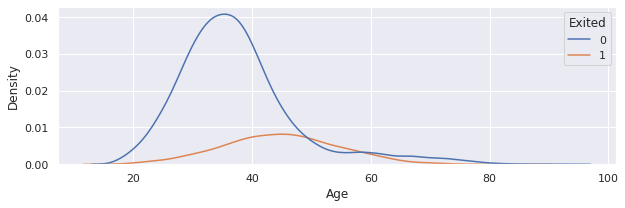

Categorical: Exited Numerical: Tenure


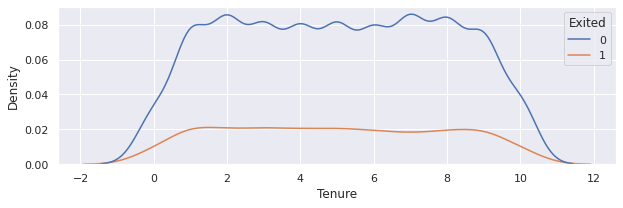

Categorical: Exited Numerical: Balance


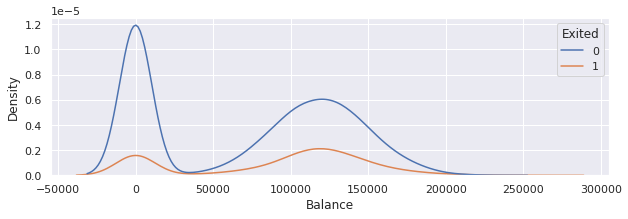

Categorical: Exited Numerical: EstimatedSalary


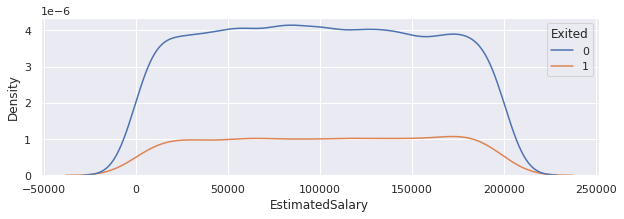

In [19]:
#CATEGORICAL TO NUMERICAL
for i in categorical:
  for j in numerical:
    print('Categorical:',i,'Numerical:',j)
    plt.figure(figsize = (10,2.9))
    sns.set_theme(style="darkgrid")
    sns.kdeplot(x = j, hue =i , data = DF)
    plt.show()

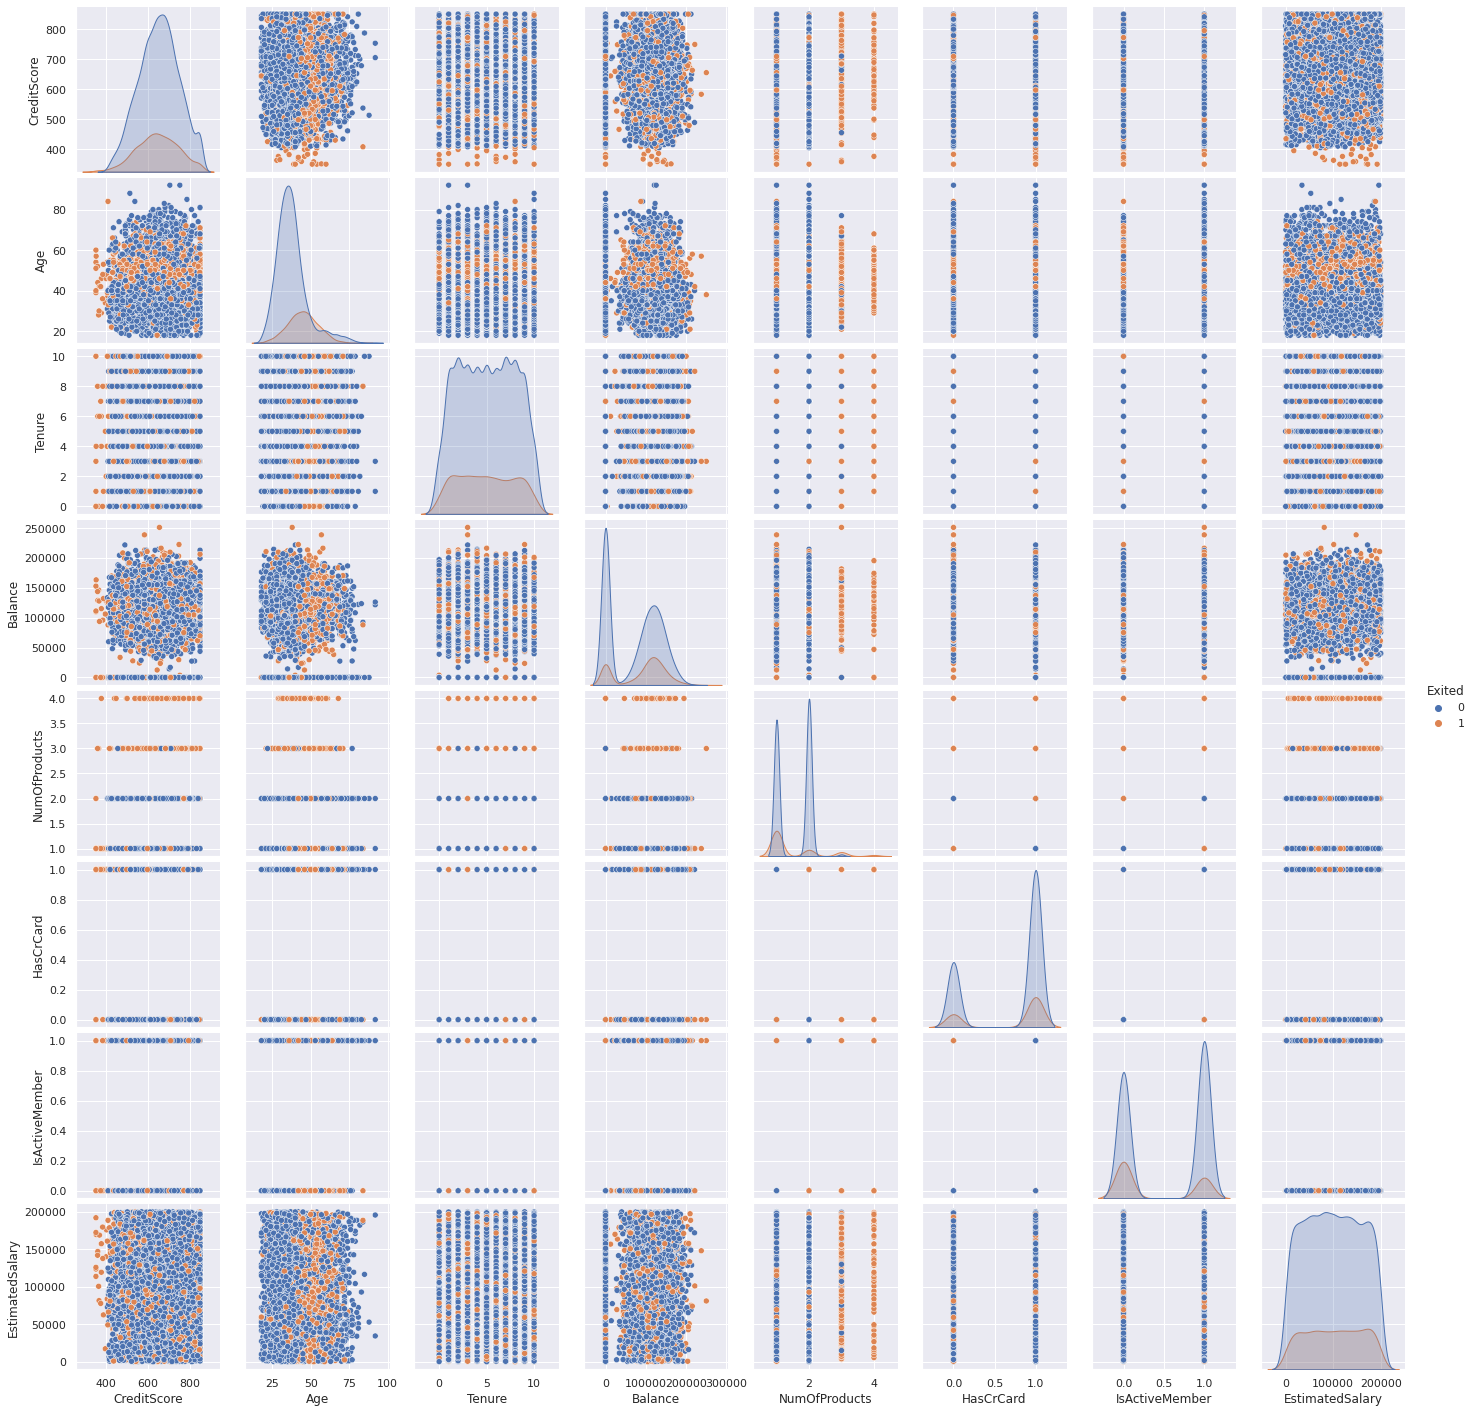

In [20]:
#NUMERICAL TO NUMERICAL
sns.pairplot(DF, hue='Exited')

**CONCLUSION from bivariate analysis:-**

*1)In france ,less number of customers are exited even though 50% of customers are from here and More male customers are there from France while customers from germany are leaving more*

*2)Both the genders purchased one or more product.Half of the female customers are not active while comparing with male and More female customers are leaving*

*3)Customers who purchased 2 products are little more active while comparing with other products purchased customers and Customers who purchased more than two products are leaving while comparing with other products purchased customers and even 1 product purchased customers*

*4)The customers who have credit card and active member are not leaving while comparing with the customers who doesn't have*

*5)75 % Customers in Germany have high balance while comparing with others

##Data Preprocessing

In [21]:
DF1.loc[DF1['HasCrCard']==1,'HasCrCard']='HasCard'
DF1.loc[DF1['HasCrCard']==0,'HasCrCard']='NoCard'
DF1.loc[DF1['IsActiveMember']==1,'IsActiveMember']='Active'
DF1.loc[DF1['IsActiveMember']==0,'IsActiveMember']='NotActive'
DF1.loc[DF1['NumOfProducts']==1,'NumOfProducts']='Product1'
DF1.loc[DF1['NumOfProducts']==2,'NumOfProducts']='Product2'
DF1.loc[DF1['NumOfProducts']==3,'NumOfProducts']='Product3'
DF1.loc[DF1['NumOfProducts']==4,'NumOfProducts']='Product4'

In [22]:
#ONE HOT ENCODING
enc = OneHotEncoder(sparse=False)
onehot = enc.fit_transform(DF1[['Geography','Gender','HasCrCard','IsActiveMember','NumOfProducts']])

In [23]:
cols=[]
for j in range(0,5):
  for i in list(enc.categories_[j]):
    cols.append(i)
df=pd.DataFrame(onehot,columns=cols)
df.head(2)

,France,Germany,Spain,Female,Male,HasCard,NoCard,Active,NotActive,Product1,Product2,Product3,Product4
0,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00


In [24]:
DF1.drop(['Geography','Gender','HasCrCard','IsActiveMember','NumOfProducts'],axis=1,inplace=True)
DF2=pd.concat([DF1,df],axis=1)
DF2.head(2)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,HasCard,NoCard,Active,NotActive,Product1,Product2,Product3,Product4
0,619,42,2,0.00,101348.88,1,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,608,41,1,83807.86,112542.58,0,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00


In [25]:
sc = MinMaxScaler()
df_scaled=sc.fit_transform(DF2[['CreditScore','Age','Tenure','Balance',	'EstimatedSalary']])
df_scale=pd.DataFrame(df_scaled,columns=['CreditScore','Age','Tenure','Balance',	'EstimatedSalary'])
df_scale

,CreditScore,Age,Tenure,Balance,EstimatedSalary
0,0.54,0.32,0.20,0.00,0.51
1,0.52,0.31,0.10,0.33,0.56
2,0.30,0.32,0.80,0.64,0.57
3,0.70,0.28,0.10,0.00,0.47
4,1.00,0.34,0.20,0.50,0.40
...,...,...,...,...,...
9995,0.84,0.28,0.50,0.00,0.48
9996,0.33,0.23,1.00,0.23,0.51
9997,0.72,0.24,0.70,0.00,0.21
9998,0.84,0.32,0.30,0.30,0.46


In [26]:
DF2.drop(['CreditScore','Age','Tenure','Balance',	'EstimatedSalary'],axis=1,inplace=True)

In [27]:
DF3=pd.concat([df_scale,DF2],axis=1)
DF3

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,HasCard,NoCard,Active,NotActive,Product1,Product2,Product3,Product4
0,0.54,0.32,0.20,0.00,0.51,1,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,0.52,0.31,0.10,0.33,0.56,0,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00
2,0.30,0.32,0.80,0.64,0.57,1,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
3,0.70,0.28,0.10,0.00,0.47,0,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00
4,1.00,0.34,0.20,0.50,0.40,0,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.84,0.28,0.50,0.00,0.48,0,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
9996,0.33,0.23,1.00,0.23,0.51,0,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
9997,0.72,0.24,0.70,0.00,0.21,1,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00
9998,0.84,0.32,0.30,0.30,0.46,1,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00


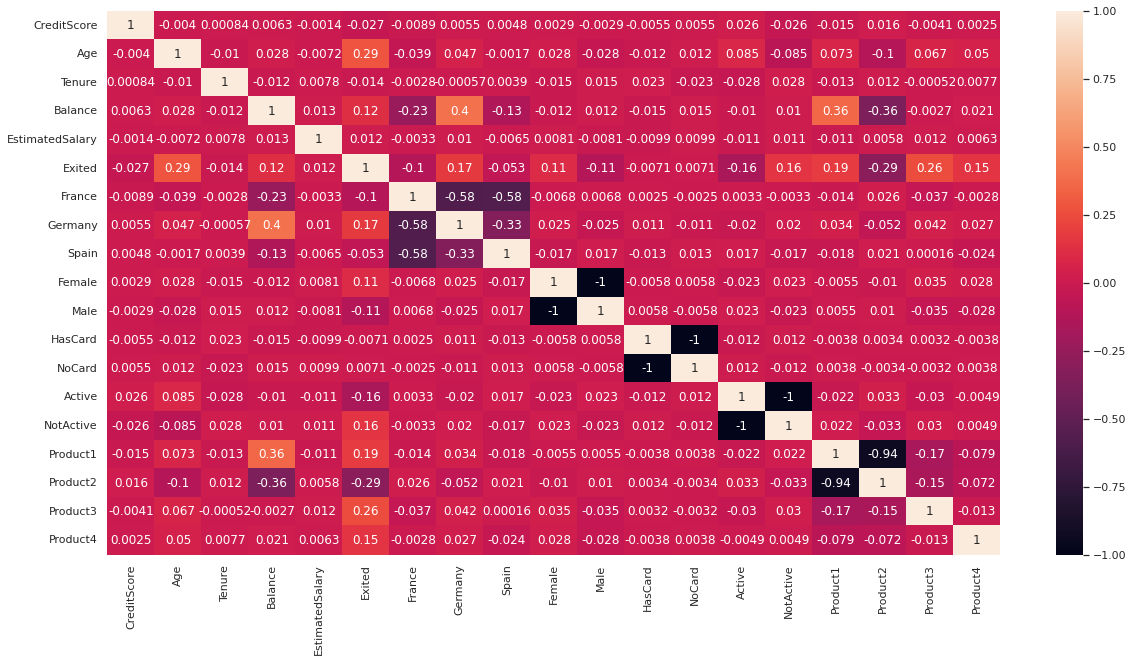

In [28]:
#CHECKING THE CORRELATION TO SELECT THE FEATURES WHICH ARE IMPORTANT IN CUSTOMERS EXIT
plt.figure(figsize=(20,10))
sns.heatmap(DF3.corr(),annot=True)
plt.show()

And the columns which are important for customers churn is:-

**Age,Balance,Geography-Germany,Sex-Female,Not active and Product 1,3,4**



In [29]:
DF3=DF3.drop(['CreditScore','Tenure','EstimatedSalary','Spain','HasCard','NoCard'],axis=1)
DF3.head(2)

,Age,Balance,Exited,France,Germany,Female,Male,Active,NotActive,Product1,Product2,Product3,Product4
0,0.32,0.00,1,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,0.31,0.33,0,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00


##Data preparation
Finding best test size as 0.2 and random state as 50

In [30]:
#SPLITTING THE COLUMNS
X=DF3.drop('Exited', axis =1)
y=DF3[['Exited']]
X.shape,y.shape

((10000, 12), (10000, 1))

In [31]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exited  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB


####LAZY PREDICT

In [32]:
def state_split(size,state):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =size, random_state =state)
  clf=LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
  models,predictions=clf.fit(X_train,X_test,y_train,y_test)
  return models.iloc[:2]

In [33]:
state_split(0.2,42)

100%|██████████| 29/29 [00:17<00:00,  1.70it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.74,0.74,0.74,0.76,0.04
XGBClassifier,0.86,0.73,0.73,0.85,0.66


In [34]:
state_split(0.2,50)

100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
KNeighborsClassifier,0.85,0.73,0.73,0.85,0.35
LabelPropagation,0.86,0.73,0.73,0.85,2.97


In [35]:
state_split(0.2,110)

100%|██████████| 29/29 [00:21<00:00,  1.36it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.77,0.75,0.75,0.78,0.05
NearestCentroid,0.74,0.74,0.74,0.76,0.04


In [36]:
state_split(0.2,7)

100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.74,0.74,0.74,0.77,0.03
KNeighborsClassifier,0.86,0.73,0.73,0.85,0.35


##Modelling

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state =50)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((8000, 12), (8000, 1), (2000, 12), (2000, 1))

In [38]:
from sklearn import metrics
def modelpredreport_proba(model_name):
  model=model_name
  model.fit(X_train,y_train)
  pred=model.predict(X_test)
  print(classification_report(y_test,pred))
  print('Confusion matrix:\n',confusion_matrix(y_test,pred))
  
def best_model(model):
    print(model.best_score_)    
    print(model.best_estimator_)

def get_auc_scores(y_test, pred,proba):
    auc_score = roc_auc_score(y_test, pred); 
    fpr_df, tpr_df, _ = roc_curve(y_test, proba); 
    return (auc_score, fpr_df, tpr_df)


###SELECTION OF CLASSIFICATION MODEL

####LOGISTIC REGRESSION

In [39]:
modelpredreport_proba(LR())

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1598
           1       0.69      0.39      0.50       402

    accuracy                           0.84      2000
   macro avg       0.78      0.67      0.70      2000
weighted avg       0.83      0.84      0.82      2000

Confusion matrix:
 [[1528   70]
 [ 245  157]]


In [40]:
#FINDING BEST PARAMETERS
kf = KFold(n_splits=2)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[10,50,100,500]}
    grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],
            'intercept_scaling':[1],'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

    clf = LR()

    clf_cv=GridSearchCV(clf,grid, cv=5)
    clf_cv.fit(X_train,y_train)
    best_model(clf_cv)

0.8443999999999999
LogisticRegression(C=0.5, max_iter=250, solver='liblinear', tol=1e-05)
0.8399999999999999
LogisticRegression(C=0.5, max_iter=250, solver='liblinear', tol=1e-05)


In [41]:
#BEST MODEL
modelpredreport_proba(LR(C=0.5, max_iter=250, solver='liblinear', tol=1e-05))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4009
           1       0.72      0.37      0.49       991

    accuracy                           0.85      5000
   macro avg       0.79      0.67      0.70      5000
weighted avg       0.83      0.85      0.83      5000

Confusion matrix:
 [[3866  143]
 [ 621  370]]


####SVC

In [42]:
modelpredreport_proba(SVC())

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4009
           1       0.79      0.37      0.50       991

    accuracy                           0.86      5000
   macro avg       0.83      0.67      0.71      5000
weighted avg       0.85      0.86      0.83      5000

Confusion matrix:
 [[3912   97]
 [ 626  365]]


In [43]:
#FINDING BEST PARAMETERS
kf = KFold(n_splits=2)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[10,50,100,500]}
    grid = {'C': [0.5,100,150], 'gamma': [0.1,0.01,0.001],'probability':[True],'kernel': ['rbf']}

    clf_cv=GridSearchCV(SVC(),grid, cv=5,verbose=0)
    clf_cv.fit(X_train,y_train)
    best_model(clf_cv)

0.8568
SVC(C=100, gamma=0.1, probability=True)
0.8532
SVC(C=100, gamma=0.1, probability=True)


In [44]:
#BEST MODEL
modelpredreport_proba(SVC(C=100, gamma=0.1, probability=True))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4009
           1       0.78      0.39      0.52       991

    accuracy                           0.86      5000
   macro avg       0.82      0.68      0.72      5000
weighted avg       0.85      0.86      0.84      5000

Confusion matrix:
 [[3903  106]
 [ 609  382]]


####RANDOM FOREST CLASSIFIER

In [45]:
modelpredreport_proba(RFC())

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4009
           1       0.64      0.48      0.55       991

    accuracy                           0.84      5000
   macro avg       0.76      0.71      0.73      5000
weighted avg       0.83      0.84      0.83      5000

Confusion matrix:
 [[3739  270]
 [ 514  477]]


In [46]:
#FINDING BEST PARAMETERS
kf = KFold(n_splits=2)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[10,50,100,500]}
    grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],
            'n_estimators':[50,100],'min_samples_split': [3, 5, 6, 7]}

    clf_cv=GridSearchCV(RFC(),grid, cv=5,verbose=0)
    clf_cv.fit(X_train,y_train)
    best_model(clf_cv)

0.865
RandomForestClassifier(max_depth=6, max_features=6, min_samples_split=7)
0.8649999999999999
RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=5)


In [47]:
#BEST MODEL
modelpredreport_proba(RFC(max_depth=6, max_features=6, min_samples_split=6,n_estimators=50))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      4009
           1       0.76      0.42      0.54       991

    accuracy                           0.86      5000
   macro avg       0.82      0.69      0.73      5000
weighted avg       0.85      0.86      0.84      5000

Confusion matrix:
 [[3881  128]
 [ 578  413]]


In [48]:
#BEST MODEL
modelpredreport_proba(RFC(max_depth=8, max_features=7, min_samples_split=3,n_estimators=50))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4009
           1       0.74      0.46      0.56       991

    accuracy                           0.86      5000
   macro avg       0.81      0.71      0.74      5000
weighted avg       0.85      0.86      0.85      5000

Confusion matrix:
 [[3854  155]
 [ 540  451]]


####ADA BOOST CLASSIFIER

In [49]:
modelpredreport_proba(ABC())

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4009
           1       0.71      0.47      0.57       991

    accuracy                           0.86      5000
   macro avg       0.80      0.71      0.74      5000
weighted avg       0.85      0.86      0.85      5000

Confusion matrix:
 [[3820  189]
 [ 522  469]]


In [50]:
#FINDING BEST PARAMETERS
kf =KFold(n_splits=2)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[10,50,100,500]}
    grid = {'algorithm':['SAMME', 'SAMME.R'],'learning_rate':[0.1,0.2,0.3,0.4,0.5],
            'n_estimators':[50,100,200]}

    clf_cv=GridSearchCV(ABC(),grid, cv=5,verbose=0)
    clf_cv.fit(X_train,y_train)
    best_model(clf_cv)

0.8582000000000001
AdaBoostClassifier(learning_rate=0.5, n_estimators=100)
0.8552
AdaBoostClassifier(learning_rate=0.5)


In [51]:
#BEST MODEL
modelpredreport_proba(ABC(learning_rate=0.5, n_estimators=100))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4009
           1       0.71      0.46      0.56       991

    accuracy                           0.86      5000
   macro avg       0.79      0.71      0.74      5000
weighted avg       0.84      0.86      0.84      5000

Confusion matrix:
 [[3826  183]
 [ 538  453]]


####DECISION TREE CLASSIFIER

In [52]:
modelpredreport_proba(DTC())

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4009
           1       0.52      0.50      0.51       991

    accuracy                           0.81      5000
   macro avg       0.70      0.69      0.70      5000
weighted avg       0.81      0.81      0.81      5000

Confusion matrix:
 [[3551  458]
 [ 493  498]]


In [53]:
#FINDING BEST PARAMETERS
kf =KFold(n_splits=5)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[10,50,100,500]}
    grid = {'criterion':['gini', 'entropy'],'max_depth': [2,4,6,8,10,12]}

    clf_cv=GridSearchCV(DTC(),grid, cv=5,verbose=0)
    clf_cv.fit(X_train,y_train)
    best_model(clf_cv)

0.858
DecisionTreeClassifier(max_depth=6)
0.856625
DecisionTreeClassifier(criterion='entropy', max_depth=8)
0.85625
DecisionTreeClassifier(criterion='entropy', max_depth=8)
0.84975
DecisionTreeClassifier(max_depth=6)
0.8568749999999999
DecisionTreeClassifier(max_depth=8)


In [54]:
#BEST MODEL
modelpredreport_proba(DTC(max_depth=6))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1610
           1       0.67      0.43      0.52       390

    accuracy                           0.85      2000
   macro avg       0.77      0.69      0.71      2000
weighted avg       0.83      0.85      0.83      2000

Confusion matrix:
 [[1526   84]
 [ 223  167]]


####KNEIGHBOURS CLASSIFIER

In [55]:
modelpredreport_proba(KNC())

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1610
           1       0.64      0.48      0.55       390

    accuracy                           0.85      2000
   macro avg       0.76      0.71      0.73      2000
weighted avg       0.84      0.85      0.84      2000

Confusion matrix:
 [[1507  103]
 [ 203  187]]


In [56]:
#FINDING BEST PARAMETERS
kf =KFold(n_splits=2)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "max_iter":[10,50,100,500]}
    grid = {'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

    clf_cv=GridSearchCV(KNC(),grid, cv=5,verbose=0)
    clf_cv.fit(X_train,y_train)
    best_model(clf_cv)

0.8533999999999999
KNeighborsClassifier(n_neighbors=13)
0.8533999999999999
KNeighborsClassifier(metric='manhattan', n_neighbors=9)


In [57]:
#BEST MODEL
modelpredreport_proba(KNC(metric='manhattan', n_neighbors=15))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4009
           1       0.72      0.43      0.54       991

    accuracy                           0.85      5000
   macro avg       0.80      0.70      0.73      5000
weighted avg       0.84      0.85      0.84      5000

Confusion matrix:
 [[3841  168]
 [ 560  431]]


###ROC CURVE

In [58]:
Logreg=LR(C=0.5, max_iter=250, solver='liblinear', tol=1e-05)
Logreg.fit(X_train,y_train)

LogisticRegression(C=0.5, max_iter=250, solver='liblinear', tol=1e-05)

In [59]:
y_pred = Logreg.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.8270950150254763


In [60]:
svc=SVC(C=100, gamma=0.1, probability=True)
svc.fit(X_train,y_train)

SVC(C=100, gamma=0.1, probability=True)

In [61]:
y_pred = svc.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.804086994977748


In [62]:
rfc=RFC(max_depth=8, max_features=7, min_samples_split=3,n_estimators=50)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, max_features=7, min_samples_split=3,
                       n_estimators=50)

In [63]:
y_pred = rfc.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.862994689798609


In [64]:
abc=ABC(learning_rate=0.9, n_estimators=100)
abc.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.9, n_estimators=100)

In [65]:
y_pred = abc.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.8480586943755964


In [66]:
dtc=DTC(max_depth=6)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

In [67]:
y_pred = dtc.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.8252668881494941


In [68]:
knc=KNC(metric='manhattan', n_neighbors=15)
knc.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15)

In [69]:
y_pred = knc.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred[:,1]))

0.8333973081253355


In [70]:
auc_LOG, fpr_LOG, tpr_LOG = get_auc_scores(y, Logreg.predict(X),Logreg.predict_proba(X)[:,1])
auc_SVC, fpr_SVC, tpr_SVC = get_auc_scores(y, svc.predict(X),svc.predict_proba(X)[:,1])
auc_RFC, fpr_RFC, tpr_RFC = get_auc_scores(y, rfc.predict(X),rfc.predict_proba(X)[:,1])
auc_ABC, fpr_ABC, tpr_ABC = get_auc_scores(y, abc.predict(X),abc.predict_proba(X)[:,1])
auc_DTC, fpr_DTC, tpr_DTC = get_auc_scores(y, dtc.predict(X),dtc.predict_proba(X)[:,1])
auc_KNC, fpr_KNC, tpr_KNC = get_auc_scores(y, knc.predict(X),knc.predict_proba(X)[:,1])

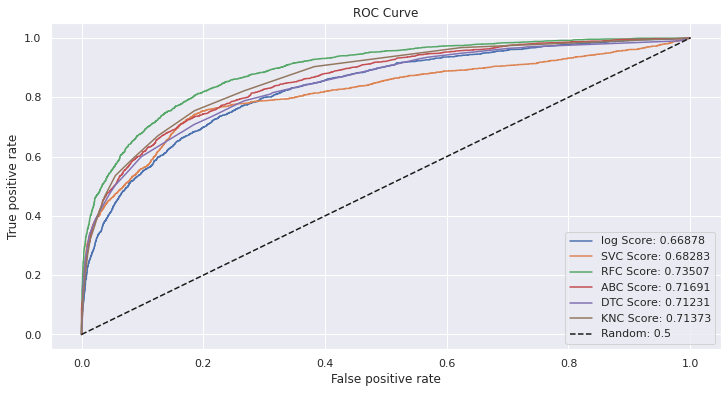

In [71]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_LOG, tpr_LOG, label = 'log Score: ' + str(round(auc_LOG, 5)))
plt.plot(fpr_SVC, tpr_SVC, label = 'SVC Score: ' + str(round(auc_SVC, 5)))
plt.plot(fpr_RFC, tpr_RFC, label = 'RFC Score: ' + str(round(auc_RFC, 5)))
plt.plot(fpr_ABC, tpr_ABC, label = 'ABC Score: ' + str(round(auc_ABC, 5)))
plt.plot(fpr_DTC, tpr_DTC, label = 'DTC Score: ' + str(round(auc_DTC, 5)))
plt.plot(fpr_KNC, tpr_KNC, label = 'KNC Score: ' + str(round(auc_KNC, 5)))

plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

ROC curve, also known as Receiver Operating Characteristics Curve, is a metric used to measure the performance of a classifier model. The ROC curve depicts the rate of true positives with respect to the rate of false positives, therefore highlighting the sensitivity of the classifier model.

###NEURAL NETWORK

In [72]:
import tensorflow as tf
from tensorflow import keras

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state =50)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((8000, 12), (8000, 1), (2000, 12), (2000, 1))

In [74]:
# Define sequential model
tf.random.set_seed(50)
model = keras.Sequential([
    # input layer
    keras.layers.Dense(100, input_shape=(12,), activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(4,activation = 'relu'),
    # we use sigmoid for binary output
    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

In [75]:
# Compiling the model
model.compile(keras.optimizers.Adam(lr = 0.01),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
# now we fit our model to training data
model.fit(X_train,y_train,epochs=100,verbose=0)

In [76]:
# evalute the model
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.3658 - accuracy: 0.8615


[0.36582985520362854, 0.8615000247955322]

In [77]:
# predict the churn values
ypred = model.predict(X_test)
print(ypred)
# unscaling the ypred values 
ypred_lis = []
for i in ypred:
    if i>0.5:
        ypred_lis.append(1)
    else:
        ypred_lis.append(0)
print(ypred_lis)

[[0.6229457 ]
 [0.00622132]
 [0.49089643]
 ...
 [0.00947028]
 [0.1597322 ]
 [0.37085697]]
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

In [82]:
#print classification_report
print(classification_report(y_test,ypred_lis))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1598
           1       0.74      0.48      0.58       402

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [90]:
confusion_matrix(y_test,ypred_lis)

array([[1532,   66],
       [ 211,  191]])

Hence we are choosing **Neural network** as the **F1-SCORE** for 0 is 0.92 and 1 is 0.58.So this model can recall 48% of the customer who left the bank and 96 % of the customers who are still with bank.And the model giving(matching with true values) 88 % precise value for people who are still in the bank and 74 % for who left the bank.

##INFERENCE

In [252]:
y_test1=np.array(y_test)
ypred_lis=np.array(ypred_lis)
ypred_lis=ypred_lis.reshape(2000,1)

In [253]:
cdf=pd.DataFrame(y_test1,columns=['Original-EXIT'])
cdf['Predicted-EXIT']=ypred_lis
cdf.head(2)

,Original-EXIT,Predicted-EXIT
0,0,1
1,0,0


In [254]:
cdf['Original-EXIT'].value_counts()

0    1598
1     402
Name: Original-EXIT, dtype: int64

In [255]:
cdf['Predicted-EXIT'].value_counts()
'CreditScore','Age','Tenure','Balance',	'EstimatedSalary'

('CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary')

In [256]:
ind=X_train.index

In [257]:
DF22=DF2.drop(['Exited'],axis=1)

In [258]:
DF4=pd.concat([DF1,DF22],axis=1)
DF4.head(2)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,HasCard,NoCard,Active,NotActive,Product1,Product2,Product3,Product4
0,619,42,2,0.00,101348.88,1,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
1,608,41,1,83807.86,112542.58,0,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00


In [259]:
DFF=DF4.iloc[ind].reset_index()
DFF.drop(['index'],axis=1,inplace=True)
DFF.tail(2)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,France,Germany,Spain,Female,Male,HasCard,NoCard,Active,NotActive,Product1,Product2,Product3,Product4
7998,395,34,5,106011.59,17376.57,1,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
7999,786,37,7,165896.22,66977.68,0,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [260]:
ind1=X_test.index

In [261]:
DFF1=DF4.iloc[ind1].reset_index()
DFF1.drop(['index','Exited'],axis=1,inplace=True)
DFF1['PExit']=cdf['Predicted-EXIT']
DFF1.tail(2)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,France,Germany,Spain,Female,Male,HasCard,NoCard,Active,NotActive,Product1,Product2,Product3,Product4,PExit
1998,711,58,9,91285.13,26767.85,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0
1999,611,36,10,103294.56,160548.12,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0


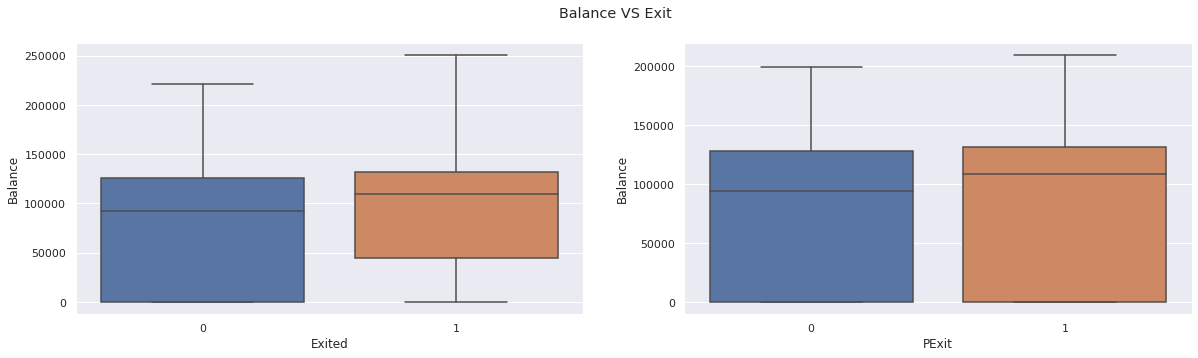

In [262]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.boxplot(y='Balance',x='Exited',data=DFF,ax=ax[0])
sns.boxplot(y='Balance',x='PExit',data=DFF1,ax=ax[1])
plt.suptitle('Balance VS Exit')
plt.show()

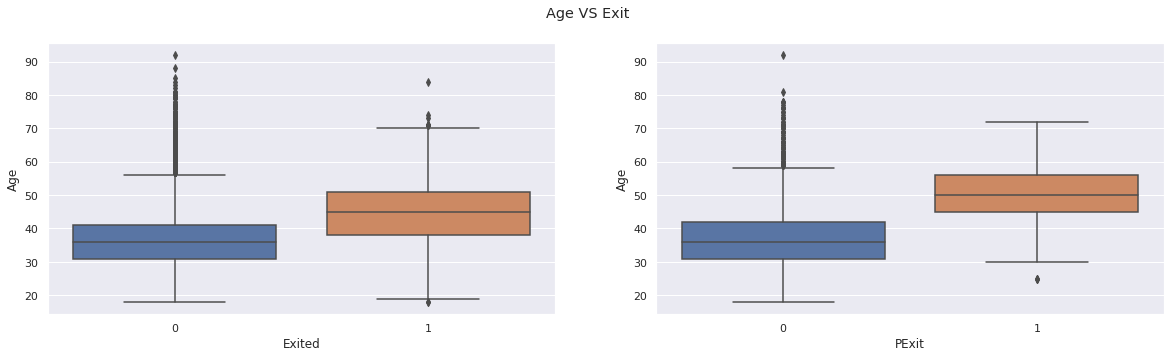

In [263]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.boxplot(y='Age',x='Exited',data=DFF,ax=ax[0])
sns.boxplot(y='Age',x='PExit',data=DFF1,ax=ax[1])
plt.suptitle('Age VS Exit')
plt.show()

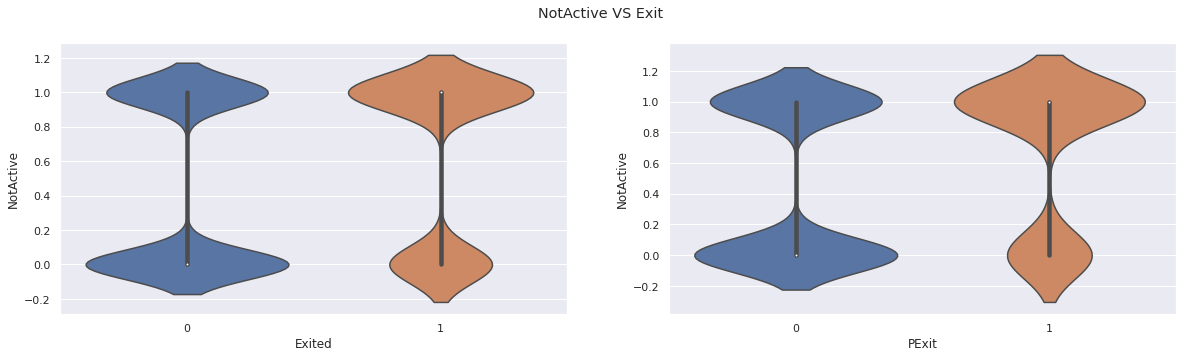

In [264]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.violinplot(y='NotActive',x='Exited',data=DFF,ax=ax[0])
sns.violinplot(y='NotActive',x='PExit',data=DFF1,ax=ax[1])
plt.suptitle('NotActive VS Exit')
plt.show()

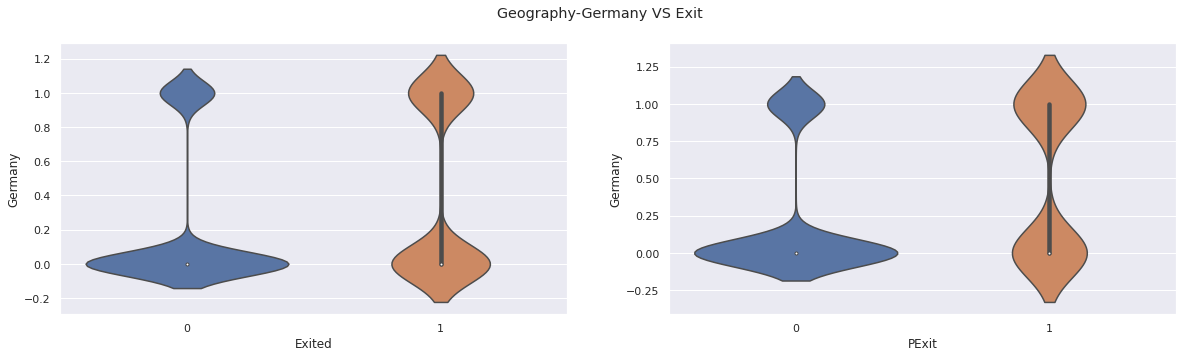

In [268]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.violinplot(y='Germany',x='Exited',data=DFF,ax=ax[0])
sns.violinplot(y='Germany',x='PExit',data=DFF1,ax=ax[1])
plt.suptitle('Geography-Germany VS Exit')
plt.show()

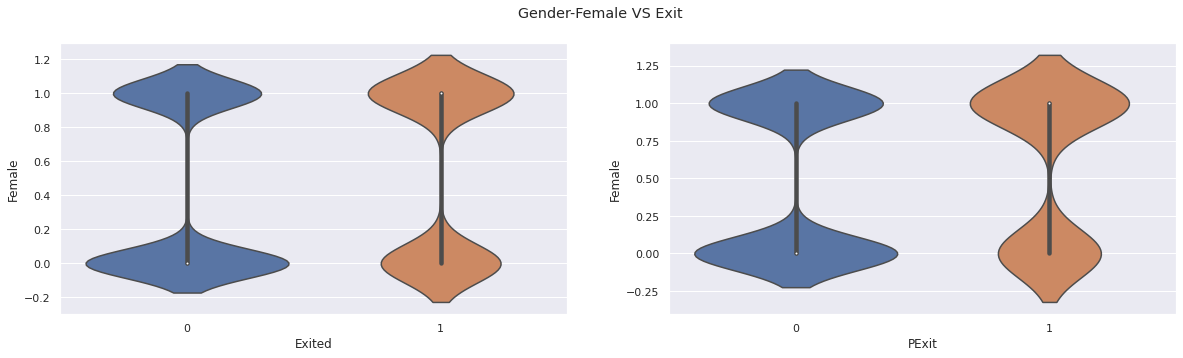

In [266]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.violinplot(y='Female',x='Exited',data=DFF,ax=ax[0])
sns.violinplot(y='Female',x='PExit',data=DFF1,ax=ax[1])
plt.suptitle('Gender-Female VS Exit')
plt.show()